# Predict Future Trend

---

### Import Libraries and Dependencies

In [1]:
# Initial imports
import os
import pandas as pd
from pathlib import Path
import datetime as dt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
%matplotlib inline

import talib

### Read CSV / API into Pandas DataFrame

In [2]:
# Read data file
file_path = Path("Resources/Data/AAPL.csv")
df = pd.read_csv(file_path, index_col="Date")
current_ticker = df.Ticker.unique().tolist()[0]
print(current_ticker)
df.head()

AAPL


,High,Low,Open,Close,Volume,Adj Close,Ticker
Date,,,,,,,
2010-01-04,7.660714,7.585000,7.622500,7.643214,493729600.0,6.593423,AAPL
2010-01-05,7.699643,7.616071,7.664286,7.656429,601904800.0,6.604822,AAPL
2010-01-06,7.686786,7.526786,7.656429,7.534643,552160000.0,6.499765,AAPL
2010-01-07,7.571429,7.466071,7.562500,7.520714,477131200.0,6.487749,AAPL
2010-01-08,7.571429,7.466429,7.510714,7.570714,447610800.0,6.530882,AAPL


### Preparing Data

In [3]:
#df = df.drop(["Adj Close", "Ticker"], axis=1)

stock_high = df['High']
stock_low = df['Low']
stock_open = df['Open']
stock_close = df['Adj Close'] # df['Close']
stock_volume = df['Volume']

### Calculate Daily Returns and Target Column

In [4]:
# Calculate daily return
df['Returns'] = stock_close.pct_change()

# Create Target column
df['Target'] = np.where(df['Returns'] >= 0, 1.0, -1)

In [5]:
# MACD
df['MACD'], df['MSIG'], df['MACDH'] = talib.MACD(stock_close, fastperiod=12, slowperiod=26, signalperiod=9)

# MACD > MSIG: Buy
# MACD < MSIG: Sell
df['MACD Sig'] = np.where(df['MACD'] > df['MSIG'], 1, 0) + np.where(df['MACD'] < df['MSIG'], -1, 0)

# MACD Histogram (MACDH) 
df['MACDH Sig'] = np.where(df['MACDH'] > 0, 1, 0) + np.where(df['MACDH'] < 0, -1, 0)

# Calculate the points in time at which a position should be taken, 1 or -1
#df['Entry/Exit'] = df['MACD Sig'].diff()

#df.loc[df['MACD Sig'] == -1]
df.tail()

,High,Low,Open,Close,Volume,Adj Close,Ticker,Returns,Target,MACD,MSIG,MACDH,MACD Sig,MACDH Sig
Date,,,,,,,,,,,,,,
2019-12-24,71.222504,70.730003,71.172501,71.067497,48478800.0,70.459007,AAPL,0.000951,1.0,1.655950,1.507072,0.148878,1,1
2019-12-26,72.495003,71.175003,71.205002,72.477501,93121200.0,71.856941,AAPL,0.019840,1.0,1.778905,1.561439,0.217467,1,1
2019-12-27,73.492500,72.029999,72.779999,72.449997,146266000.0,71.829674,AAPL,-0.000379,-1.0,1.852791,1.619709,0.233082,1,1
2019-12-30,73.172501,71.305000,72.364998,72.879997,144114400.0,72.255997,AAPL,0.005935,1.0,1.923572,1.680482,0.243091,1,1
2019-12-31,73.419998,72.379997,72.482498,73.412498,100805600.0,72.783936,AAPL,0.007307,1.0,1.999222,1.744230,0.254992,1,1


In [6]:
# Compute Average Directional Index (ADX)
df['ADX'] = talib.ADX(stock_high, stock_low, stock_close, timeperiod=14)

# ADX > 25: Strong Trend Strength 
# ADX < 20: Weak Trend Strength
df['ADX Sig'] = np.where(df['ADX'] > 25, 1, 0) + np.where(df['ADX'] < 20, -1, 0)

#df.loc[df['ADX Sig'] == 0]
df.tail()

,High,Low,Open,Close,Volume,Adj Close,Ticker,Returns,Target,MACD,MSIG,MACDH,MACD Sig,MACDH Sig,ADX,ADX Sig
Date,,,,,,,,,,,,,,,,
2019-12-24,71.222504,70.730003,71.172501,71.067497,48478800.0,70.459007,AAPL,0.000951,1.0,1.655950,1.507072,0.148878,1,1,33.984310,1
2019-12-26,72.495003,71.175003,71.205002,72.477501,93121200.0,71.856941,AAPL,0.019840,1.0,1.778905,1.561439,0.217467,1,1,35.781144,1
2019-12-27,73.492500,72.029999,72.779999,72.449997,146266000.0,71.829674,AAPL,-0.000379,-1.0,1.852791,1.619709,0.233082,1,1,37.826591,1
2019-12-30,73.172501,71.305000,72.364998,72.879997,144114400.0,72.255997,AAPL,0.005935,1.0,1.923572,1.680482,0.243091,1,1,38.647666,1
2019-12-31,73.419998,72.379997,72.482498,73.412498,100805600.0,72.783936,AAPL,0.007307,1.0,1.999222,1.744230,0.254992,1,1,39.528289,1


In [7]:
# Compute Relatie Strength Index (RSI)
df['RSI'] = talib.RSI(stock_close, timeperiod=14)

# RSI < 30: Over sold -> Buy
# RSI > 70: Over bought -> Sell
df['RSI Sig'] = np.where(df['RSI'] < 30, 1, 0) + np.where(df['RSI'] > 70, -1, 0)

df.tail()

,High,Low,Open,Close,Volume,Adj Close,Ticker,Returns,Target,MACD,MSIG,MACDH,MACD Sig,MACDH Sig,ADX,ADX Sig,RSI,RSI Sig
Date,,,,,,,,,,,,,,,,,,
2019-12-24,71.222504,70.730003,71.172501,71.067497,48478800.0,70.459007,AAPL,0.000951,1.0,1.655950,1.507072,0.148878,1,1,33.984310,1,74.497944,-1
2019-12-26,72.495003,71.175003,71.205002,72.477501,93121200.0,71.856941,AAPL,0.019840,1.0,1.778905,1.561439,0.217467,1,1,35.781144,1,78.723010,-1
2019-12-27,73.492500,72.029999,72.779999,72.449997,146266000.0,71.829674,AAPL,-0.000379,-1.0,1.852791,1.619709,0.233082,1,1,37.826591,1,78.449991,-1
2019-12-30,73.172501,71.305000,72.364998,72.879997,144114400.0,72.255997,AAPL,0.005935,1.0,1.923572,1.680482,0.243091,1,1,38.647666,1,79.638961,-1
2019-12-31,73.419998,72.379997,72.482498,73.412498,100805600.0,72.783936,AAPL,0.007307,1.0,1.999222,1.744230,0.254992,1,1,39.528289,1,81.034426,-1


In [8]:
# Compute Bollinger Bands
df['BB Upper'], df['BB middle'], df['BB Lower'] = talib.BBANDS(stock_close, timeperiod=26)

# 
df['BB Sig'] = np.where(stock_close < df['BB Lower'], 1, 0) + np.where(stock_close > df['BB Upper'], -1, 0)

df.tail()

,High,Low,Open,Close,Volume,Adj Close,Ticker,Returns,Target,MACD,...,MACD Sig,MACDH Sig,ADX,ADX Sig,RSI,RSI Sig,BB Upper,BB middle,BB Lower,BB Sig
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-24,71.222504,70.730003,71.172501,71.067497,48478800.0,70.459007,AAPL,0.000951,1.0,1.655950,...,1,1,33.984310,1,74.497944,-1,70.664015,67.000994,63.337972,0
2019-12-26,72.495003,71.175003,71.205002,72.477501,93121200.0,71.856941,AAPL,0.019840,1.0,1.778905,...,1,1,35.781144,1,78.723010,-1,71.312147,67.218443,63.124739,-1
2019-12-27,73.492500,72.029999,72.779999,72.449997,146266000.0,71.829674,AAPL,-0.000379,-1.0,1.852791,...,1,1,37.826591,1,78.449991,-1,71.869904,67.442565,63.015226,0
2019-12-30,73.172501,71.305000,72.364998,72.879997,144114400.0,72.255997,AAPL,0.005935,1.0,1.923572,...,1,1,38.647666,1,79.638961,-1,72.416223,67.712636,63.009049,0
2019-12-31,73.419998,72.379997,72.482498,73.412498,100805600.0,72.783936,AAPL,0.007307,1.0,1.999222,...,1,1,39.528289,1,81.034426,-1,72.967561,68.014262,63.060962,0


In [9]:
# Compute Force Index
#df['FI'] = df['Volume'] * (stock_close - stock_close.shift(1))
df['FI'] = df['Volume'] * stock_close.diff()
df['EFI'] = talib.EMA(df['FI'], timeperiod=13)

# Remove Scientific Notation from columns FI and EFI
pd.options.display.float_format = '{:.2f}'.format

df['EFI Sig'] = np.where(df['EFI'] > 0, 1, -1)

df.tail()

,High,Low,Open,Close,Volume,Adj Close,Ticker,Returns,Target,MACD,...,ADX Sig,RSI,RSI Sig,BB Upper,BB middle,BB Lower,BB Sig,FI,EFI,EFI Sig
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-24,71.22,70.73,71.17,71.07,48478800.00,70.46,AAPL,0.00,1.00,1.66,...,1,74.50,-1,70.66,67.00,63.34,0,3244076.19,28048848.51,1
2019-12-26,72.50,71.18,71.21,72.48,93121200.00,71.86,AAPL,0.02,1.00,1.78,...,1,78.72,-1,71.31,67.22,63.12,-1,130177287.87,42638625.56,1
2019-12-27,73.49,72.03,72.78,72.45,146266000.00,71.83,AAPL,-0.00,-1.00,1.85,...,1,78.45,-1,71.87,67.44,63.02,0,-3988301.73,35977635.95,1
2019-12-30,73.17,71.31,72.36,72.88,144114400.00,72.26,AAPL,0.01,1.00,1.92,...,1,79.64,-1,72.42,67.71,63.01,0,61439274.27,39615012.85,1
2019-12-31,73.42,72.38,72.48,73.41,100805600.00,72.78,AAPL,0.01,1.00,2.00,...,1,81.03,-1,72.97,68.01,63.06,0,53219191.81,41558466.99,1


In [10]:
# ------------ SMA 5 AND 15 DAYS ------------

# Calculate 5 day simple movering average
df['SMA 5'] = stock_close.transform(lambda x: x.rolling(window = 5).mean())

# Calculate 15 day simple movering average
df['SMA 15'] = stock_close.transform(lambda x: x.rolling(window = 15).mean())

# Calculate simple moving average ratio to capture the relationship between the two moving averages
df['SMA 15/5'] = df['SMA 15'] / df['SMA 5']

# Calculate Signal for SMA 200/50
df['SMA 15/5 Sig'] = np.where(df['SMA 5'] > df['SMA 15'], 1.0, 0.0) + np.where(df['SMA 5'] < df['SMA 15'], -1.0, 0.0)

df.tail()

,High,Low,Open,Close,Volume,Adj Close,Ticker,Returns,Target,MACD,...,BB middle,BB Lower,BB Sig,FI,EFI,EFI Sig,SMA 5,SMA 15,SMA 15/5,SMA 15/5 Sig
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-24,71.22,70.73,71.17,71.07,48478800.00,70.46,AAPL,0.00,1.00,1.66,...,67.00,63.34,0,3244076.19,28048848.51,1,69.77,68.05,0.98,1.00
2019-12-26,72.50,71.18,71.21,72.48,93121200.00,71.86,AAPL,0.02,1.00,1.78,...,67.22,63.12,-1,130177287.87,42638625.56,1,70.28,68.52,0.98,1.00
2019-12-27,73.49,72.03,72.78,72.45,146266000.00,71.83,AAPL,-0.00,-1.00,1.85,...,67.44,63.02,0,-3988301.73,35977635.95,1,70.76,68.92,0.97,1.00
2019-12-30,73.17,71.31,72.36,72.88,144114400.00,72.26,AAPL,0.01,1.00,1.92,...,67.71,63.01,0,61439274.27,39615012.85,1,71.36,69.26,0.97,1.00
2019-12-31,73.42,72.38,72.48,73.41,100805600.00,72.78,AAPL,0.01,1.00,2.00,...,68.01,63.06,0,53219191.81,41558466.99,1,71.84,69.71,0.97,1.00


In [11]:
# ------------ EMA 15 and 5 days  ------------

# Calculate 5 day exp movering average
df['EMA 5'] = talib.EMA(stock_close, timeperiod=5)

# Calculate 10 day exp movering average
df['EMA 15'] = talib.EMA(stock_close, timeperiod=15)

# Calculate exp moving average ratio to capture the relationship between the two moving averages
df['EMA 15/5'] = df['EMA 15'] / df['EMA 5']

# Calculate Signal for SMA 200/50
df['EMA 15/5 Sig'] = np.where(df['EMA 5'] > df['SMA 15'], 1.0, 0.0) + np.where(df['SMA 5'] < df['SMA 15'], -1.0, 0.0)

df.tail()

,High,Low,Open,Close,Volume,Adj Close,Ticker,Returns,Target,MACD,...,EFI,EFI Sig,SMA 5,SMA 15,SMA 15/5,SMA 15/5 Sig,EMA 5,EMA 15,EMA 15/5,EMA 15/5 Sig
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-24,71.22,70.73,71.17,71.07,48478800.00,70.46,AAPL,0.00,1.00,1.66,...,28048848.51,1,69.77,68.05,0.98,1.00,69.83,68.39,0.98,1.00
2019-12-26,72.50,71.18,71.21,72.48,93121200.00,71.86,AAPL,0.02,1.00,1.78,...,42638625.56,1,70.28,68.52,0.98,1.00,70.50,68.83,0.98,1.00
2019-12-27,73.49,72.03,72.78,72.45,146266000.00,71.83,AAPL,-0.00,-1.00,1.85,...,35977635.95,1,70.76,68.92,0.97,1.00,70.95,69.20,0.98,1.00
2019-12-30,73.17,71.31,72.36,72.88,144114400.00,72.26,AAPL,0.01,1.00,1.92,...,39615012.85,1,71.36,69.26,0.97,1.00,71.38,69.58,0.97,1.00
2019-12-31,73.42,72.38,72.48,73.41,100805600.00,72.78,AAPL,0.01,1.00,2.00,...,41558466.99,1,71.84,69.71,0.97,1.00,71.85,69.98,0.97,1.00


In [12]:
# ATR                  Average True Range
# TO DO

In [13]:
# Shift Target column by index -1 (compare today's values with tomorrow's trend)
df['Target'] = df['Target'].shift(-1)

# Replacing infinite with nan 
df.replace([np.inf, -np.inf], np.nan, inplace=True) 
  
# Dropping all the rows with nan values 
df.dropna(inplace=True) 
df.head()

,High,Low,Open,Close,Volume,Adj Close,Ticker,Returns,Target,MACD,...,EFI,EFI Sig,SMA 5,SMA 15,SMA 15/5,SMA 15/5 Sig,EMA 5,EMA 15,EMA 15/5,EMA 15/5 Sig
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-22,7.23,7.11,7.23,7.16,390563600.00,6.17,AAPL,-0.01,-1.00,-0.08,...,1588013.67,1,6.23,6.11,0.98,1.00,6.20,6.18,1.00,1.00
2010-02-23,7.19,6.99,7.14,7.04,575094800.00,6.07,AAPL,-0.02,1.00,-0.08,...,-7143277.34,-1,6.19,6.11,0.99,1.00,6.15,6.16,1.00,1.00
2010-02-24,7.19,7.07,7.08,7.17,460566400.00,6.18,AAPL,0.02,1.00,-0.07,...,1174657.95,1,6.18,6.12,0.99,1.00,6.16,6.17,1.00,1.00
2010-02-25,7.24,7.03,7.05,7.21,665126000.00,6.22,AAPL,0.01,1.00,-0.06,...,4929490.18,1,6.17,6.13,0.99,1.00,6.18,6.17,1.00,1.00
2010-02-26,7.33,7.21,7.23,7.31,507460800.00,6.30,AAPL,0.01,1.00,-0.05,...,10077090.62,1,6.19,6.15,0.99,1.00,6.22,6.19,0.99,1.00


### Split Train and Test Data Sets

In [14]:
# Define features set
X = df.copy()

# Remove signal columns and other columns not used
X.drop([col for col in X.columns if col.endswith(' Sig')], axis=1, inplace=True)
X.drop(['Ticker', 'Returns', 'Target'], axis=1, inplace=True)


# Use signals only
#X = X[[col for col in X.columns if col.endswith(' Sig')]]

#X.drop(['Returns', 'Target'], axis=1, inplace=True)
X.head()

,High,Low,Open,Close,Volume,Adj Close,MACD,MSIG,MACDH,ADX,...,BB middle,BB Lower,FI,EFI,SMA 5,SMA 15,SMA 15/5,EMA 5,EMA 15,EMA 15/5
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-22,7.23,7.11,7.23,7.16,390563600.00,6.17,-0.08,-0.13,0.06,21.81,...,6.20,5.83,-15041661.40,1588013.67,6.23,6.11,0.98,6.20,6.18,1.00
2010-02-23,7.19,6.99,7.14,7.04,575094800.00,6.07,-0.08,-0.12,0.04,21.79,...,6.18,5.82,-59531023.43,-7143277.34,6.19,6.11,0.99,6.15,6.16,1.00
2010-02-24,7.19,7.07,7.08,7.17,460566400.00,6.18,-0.07,-0.11,0.04,21.73,...,6.18,5.82,51082269.70,1174657.95,6.18,6.12,0.99,6.16,6.17,1.00
2010-02-25,7.24,7.03,7.05,7.21,665126000.00,6.22,-0.06,-0.10,0.04,21.17,...,6.16,5.86,27458483.55,4929490.18,6.17,6.13,0.99,6.18,6.17,1.00
2010-02-26,7.33,7.21,7.23,7.31,507460800.00,6.30,-0.05,-0.09,0.05,19.91,...,6.15,5.88,40962693.25,10077090.62,6.19,6.15,0.99,6.22,6.19,0.99


In [15]:
# Define target vector
y = df["Target"].ravel()
y[:5]

array([-1.,  1.,  1.,  1.,  1.])

In [16]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.3)

### Scale Data

In [17]:
# Creating StandardScaler instance
scaler = StandardScaler()

In [18]:
# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

In [19]:
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Create Model and Make Pedictions

In [20]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=1)

In [21]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

In [22]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

### Model Evaluation

In [23]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [24]:
# Displaying results
print(f'Confusion Matrix for: {current_ticker}')
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix for: AAPL


,Predicted 0,Predicted 1
Actual 0,160,180
Actual 1,184,221


Accuracy Score : 0.5114093959731544
Classification Report
              precision    recall  f1-score   support

        -1.0       0.47      0.47      0.47       340
         1.0       0.55      0.55      0.55       405

    accuracy                           0.51       745
   macro avg       0.51      0.51      0.51       745
weighted avg       0.51      0.51      0.51       745



## Feature Importance

In [25]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_

In [26]:
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.06131560445505363, 'SMA 15/5'),
 (0.059961564845082485, 'FI'),
 (0.058226869862389515, 'MACDH'),
 (0.05802678753380727, 'Volume'),
 (0.05759552634633033, 'RSI'),
 (0.0573249614098345, 'EFI'),
 (0.05612575028211668, 'ADX'),
 (0.055787627892885765, 'EMA 15/5'),
 (0.05220248671785538, 'MACD'),
 (0.05107408153616959, 'MSIG'),
 (0.03917200276990101, 'BB Lower'),
 (0.038134798763557645, 'BB Upper'),
 (0.03776860364207625, 'Open'),
 (0.03773114367620858, 'SMA 5'),
 (0.036389821899267066, 'Close'),
 (0.03569037683741685, 'High'),
 (0.0353008151391718, 'Adj Close'),
 (0.03520128394339866, 'Low'),
 (0.034498512427429316, 'BB middle'),
 (0.03434654648660851, 'EMA 15'),
 (0.03415234745830216, 'SMA 15'),
 (0.03397248607513716, 'EMA 5')]

In [27]:
# Visualize the features by importance
print(current_ticker)
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted

AAPL


,Feature Importances
1,
EMA 5,0.03
SMA 15,0.03
EMA 15,0.03
BB middle,0.03
Low,0.04
Adj Close,0.04
High,0.04
Close,0.04
SMA 5,0.04


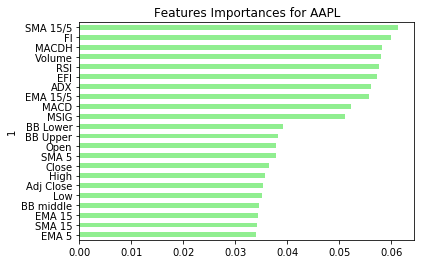

In [28]:
importances_sorted.plot(kind='barh', color='lightgreen', title= f'Features Importances for {current_ticker}', legend=False)

### Evaluate & Plot